In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from nltk.corpus import gutenberg, stopwords
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Background 

First, pick a set of texts. This can be either a series of novels, chapters, or articles. Anything you'd like. It just has to have multiple entries of varying characteristics. At least 100 should be good. There should also be at least 10 different authors, but try to keep the texts related (either all on the same topic of from the same branch of literature - something to make classification a bit more difficult than obviously different subjects).

In [2]:
# Lets look at what text I can use. 
gutenberg.fileids()

['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

In [3]:
# Pick 10 different books with 10 different authors.
austen = gutenberg.raw('austen-emma.txt')
bible = gutenberg.raw('bible-kjv.txt')
blake = gutenberg.raw('blake-poems.txt')
bryant = gutenberg.raw('bryant-stories.txt')
buster = gutenberg.raw('burgess-busterbrown.txt')
chesterton = gutenberg.raw('chesterton-thursday.txt')
edgeworth = gutenberg.raw('edgeworth-parents.txt')
milton = gutenberg.raw('milton-paradise.txt')
shakes = gutenberg.raw('shakespeare-caesar.txt')
whitman = gutenberg.raw('whitman-leaves.txt')

# Data Cleaning 

In [4]:
# Utility function to clean text.
def text_cleaner(text):
    
    # Visual inspection shows spaCy does not recognize the double dash '--'.
    # Better get rid of it now!
    text = re.sub(r'--',' ',text)
    
    # Get rid of headings in square brackets.
    text = re.sub("[\[].*?[\]]", "", text)
    
    # Get rid of chapter titles.
    text = re.sub(r'Chapter \d+','',text)
    text = re.sub(r'CHAPTER \d+', '', text)
    text = re.sub("\\n\\n.*?\\n\\n", '', text)
  
    # Get rid of extra whitespace.
    text = ' '.join(text.split())

    
    return text

In [5]:
# Clean documents
austen = text_cleaner(austen)
# Bible was over the limit for nlp so I had to limit it.
bible = text_cleaner(bible)[:99990]
blake = text_cleaner(blake)
bryant = text_cleaner(bryant)
buster = text_cleaner(buster)
chesterton = text_cleaner(chesterton)
edgeworth = text_cleaner(edgeworth)
milton = text_cleaner(milton)
shakes = text_cleaner(shakes)
whitman = text_cleaner(whitman)

In [6]:
# run spaCy and analyze the documents
nlp = spacy.load('en')


austen_doc = nlp(austen)
bible_doc = nlp(bible)
blake_doc = nlp(blake)
bryant_doc = nlp(bryant)
buster_doc = nlp(buster)
chesterton_doc = nlp(chesterton)
edgeworth_doc = nlp(edgeworth)
milton_doc = nlp(milton)
shakes_doc = nlp(shakes)
whitman_doc = nlp(whitman)

In [7]:
# Group into sentences
austen_sents = [[sent, 'austen'] for sent in austen_doc.sents]
bible_sents = [[sent, 'bible'] for sent in bible_doc.sents]
bryant_sents = [[sent, 'bryant'] for sent in bryant_doc.sents]
buster_sents = [[sent, 'buster'] for sent in buster_doc.sents]
chesterton_sents = [[sent, 'chesterton'] for sent in chesterton_doc.sents]
edgeworth_sents = [[sent, 'edgeworth'] for sent in edgeworth_doc.sents]
milton_sents = [[sent, 'milton'] for sent in milton_doc.sents]
shakes_sents = [[sent, 'shakes'] for sent in shakes_doc.sents]
whitman_sents = [[sent, 'whitman'] for sent in whitman_doc.sents]

In [8]:
# Combine the sentences from the 10 novels into one data frame.
sentences = pd.DataFrame(austen_sents + bible_sents + bryant_sents +
                        buster_sents + chesterton_sents + edgeworth_sents +
                        milton_sents + shakes_sents + whitman_sents)

In [9]:
# Add a title to the columns so we know what we are looking at.
sentences.columns = ['text', 'author']

sentences.head()

,text,author
0,"(CHAPTER, I, Emma, Woodhouse, ,, handsome, ,, ...",austen
1,"(She, was, the, youngest, of, the, two, daught...",austen
2,"(Her, mother, had, died, too, long, ago, for, ...",austen
3,"(Sixteen, years, had, Miss, Taylor, been, in, ...",austen
4,"(Between, _, them)",austen


In [10]:
# Look at the size of the data. 
sentences.shape

(37215, 2)

In [15]:
# I tried vectorizing before but the program wouldn't run.
# The error said that it wanted string type data so I checked my data type.
sentences.dtypes

text      object
author    object
dtype: object

In [13]:
# Originally, sentences was an object type, need to convert it to str type.
sentences['text'] = sentences['text'].astype('str') 
sentences['author'] = sentences['author'].astype('str') 

In [14]:
# Create a training and testing data set. 
X = sentences['text']
y = sentences['author']

# Feature Generation

## Tf-idf Vectorization

In [40]:
vectorizer = TfidfVectorizer(max_df=0.5,
                            min_df=4,
                            stop_words='english',
                            lowercase=False,
                            use_idf=True,
                            norm=u'l2',
                            smooth_idf=True)
# Applying the vectorizer
X_tfidf = vectorizer.fit_transform(X)
print('Number of features: {}'.format(X_tfidf.get_shape()[1]))

# Splitting into train and test sets
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.25, random_state=42)

# Reshape vectorizer to readable content
X_train_tfidf_csr = X_train_tfidf.tocsr()

# Number of paragraphs
n = X_train_tfidf_csr.shape[0]

# A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]

# List of features
terms = vectorizer.get_feature_names()

# For each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

# Keep in mind that the log base 2 of 1 is 0, 
# so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train[100])
print('Tf_idf vector:', tfidf_bypara[100])


Number of features: 10131
Original sentence: Oh no!
Tf_idf vector: {'Shake': 0.533733191309191, 'Corkscrew': 0.4179025907423565, 'fellow': 0.36685343522395064, 'honest': 0.38448314112456033, 'hands': 0.31609340947531134, 'glad': 0.3499317762019466, 'said': 0.188971651026113}


In [20]:
# Normalize the data.
from sklearn.preprocessing import normalize
X_norm = normalize(X_train_tfidf)

# NLP - spaCy

Rerun NLP in order to tokenize each sentence to be able to extract information about parts of speech to add as features in our models.

In [38]:
# Instantiating spaCy
nlp = spacy.load('en')
X_train_words = []

for row in X_train:
    # Processing each row for tokens
    row_doc = nlp(row)
    # Calculating length of each sentence
    sent_len = len(row_doc) 
    # Initializing counts of different parts of speech
    advs = 0
    verb = 0
    noun = 0
    adj = 0
    for token in row_doc:
        # Identifying each part of speech and adding to counts
        if token.pos_ == 'ADV':
            advs +=1
        elif token.pos_ == 'VERB':
            verb +=1
        elif token.pos_ == 'NOUN':
            noun +=1
        elif token.pos_ == 'ADJ':
            adj +=1
    # Creating a list of all features for each sentence
    X_train_words.append([row_doc, advs, verb, noun, adj, sent_len])

In [41]:
# In order to label each of these new features, I need to re index the y_train data
y_train_new = y_train.reset_index(drop=True)

In [45]:
# Put the new features together with their respective authors.
# Create a data frame for the features first.
txt_bow = pd.DataFrame(data=X_train_words, columns=['BoW', 'Adv', 'Verb', 'Noun',
                                                   'Adj', 'Sent_len'])
# Add the author data into the data frame.
txt_bow = pd.concat([txt_bow, y_train_new], ignore_index=False, axis=1)
txt_bow.head()

,BoW,Adv,Verb,Noun,Adj,Sent_len,author
0,"(I, have, said, you, should, speak, presently, .)",1,4,0,0,8,austen
1,"(And, I, see, very, few, pearls, in, the, room...",1,1,3,1,12,chesterton
2,"(O, Cicero, ,, I, haue, seene, Tempests, ,, wh...",1,7,7,1,42,whitman
3,"(You, see, he, was, n't, well, enough, acquain...",7,6,1,2,29,austen
4,"(It, is, I, ,, you, women, ,, I, make, my, way...",6,18,8,8,87,whitman


In [46]:
# Okay so I have the boW as features,
# Now I want to obtain the tf-idf features too. 
X_norm_df = pd.DataFrame(data=X_norm.toarray())
txt_tfidf_bow = pd.concat([txt_bow, X_norm_df], ignore_index=False, axis=1)
txt_tfidf_bow.head()

,BoW,Adv,Verb,Noun,Adj,Sent_len,author,0,1,2,...,10121,10122,10123,10124,10125,10126,10127,10128,10129,10130
0,"(I, have, said, you, should, speak, presently, .)",1,4,0,0,8,austen,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"(And, I, see, very, few, pearls, in, the, room...",1,1,3,1,12,chesterton,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"(O, Cicero, ,, I, haue, seene, Tempests, ,, wh...",1,7,7,1,42,whitman,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"(You, see, he, was, n't, well, enough, acquain...",7,6,1,2,29,austen,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"(It, is, I, ,, you, women, ,, I, make, my, way...",6,18,8,8,87,whitman,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
print('Final training dataframe shape:', txt_tfidf_bow.shape)

Final training dataframe shape: (27911, 10138)


In [51]:
# Identifying features and labels to choose from
features = txt_tfidf_bow.drop(['BoW', 'author'], axis=1)
y2_train = txt_tfidf_bow.author

In [70]:
# Theres too many features at the moment, so I will limit it to top 150.
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Instantiating and fitting the 150 best features
kbest = SelectKBest(chi2, k=150)
X2_train = kbest.fit_transform(features, y2_train)

# Clustering

The point of using clusters is to group the paragraphs together to see if the clusters group accordingly to their author. There will be several different clustering techniques, the first being

## K-Means Clustering

K-means clustering is an iterative algorithm that seeks to cluster based on minimizing the inertia (cost function) or the sum of squared differences between the mean of the cluster and the data points of the cluster. 

Normally, the data would have to be normalized before using K-Means so that the distance would be accurate but that has already been done up top. 

In [68]:
from sklearn.cluster import KMeans

# I will use 10 clusters because I have 10 authors.
# Initialize the model. 
kmeans = KMeans(n_clusters=10, init='k-means++', random_state=42, n_init=20)

# Fit and predict the model. 
y_pred = kmeans.fit_predict(X2_train)

pd.crosstab(y2_train, y_pred)

col_0,0,1,2,3,4,5,6,7,8,9
author,,,,,,,,,,
austen,271,1560,528,28,1,1542,910,1319,2,113
bible,50,230,86,11,0,261,138,257,0,22
bryant,101,528,164,14,2,514,289,427,3,41
buster,33,179,60,6,0,203,116,156,0,11
chesterton,87,610,190,12,0,553,335,493,0,32
edgeworth,327,1892,727,45,3,1900,1124,1535,6,121
milton,93,504,175,8,0,546,306,402,6,42
shakes,51,375,98,10,0,372,210,292,1,17
whitman,152,1028,362,20,0,1112,604,873,1,83


In [69]:
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_score
# Evaluate the performance of the clusters

print('Adjusted Rand Score: {:0.7}'.format(adjusted_rand_score(y2_train, y_pred)))
print('Silhouette Score: {:0.7}'.format(silhouette_score(X2_train, y_pred, metric='euclidean')))

Adjusted Rand Score: -0.0008466052
Silhouette Score: 0.4815564


Adjusted Rand Index is a function that measures the similarity of two assignments, ignoring permutations and with chance normalization. The score was negative which means that the similarity might as well be random. ARI has an accurate ground truth in the y-pred so it signals that the similarity isn't there.

Silhouette Coefficient is the mean distance between a sample and all other points in the same class (a), the mean distance between a sample and all other points in the next nearest cluster (b), divided by whichever of the two values is highest. Scores around 0 indicate overlapping clusters. Score is higher when clusters are dense and well separated. 

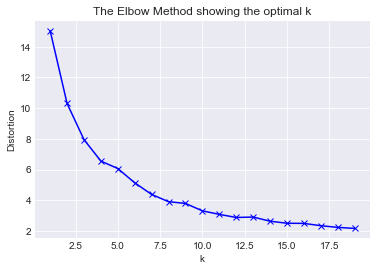

In [74]:
from scipy.spatial.distance import cdist
# Use the elbow method to see what is the optimal amount of clusters.

# k means determine k
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X2_train)
    kmeanModel.fit(X2_train)
    distortions.append(sum(np.min(cdist(X2_train, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X2_train.shape[0])

# Plot the elbow
sns.set_style('darkgrid')
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

The elbow is actually around 6 clusters but I have to use 10 in order to see if the models can label the 10 authors. 

## Mini Batch K Means 

Mini Batch won't really change much since it is only used when PCA isn't run to reduce dimensionality and search for clusters in the reduced data. Mini Batch is useful if I want to keep all the data and if I have limited computational power or time. It works by randomly sampling subsets of the training data in each iteration. 

In [64]:
from sklearn.cluster import MiniBatchKMeans

# Initialize the model. 
minikmeans = MiniBatchKMeans(n_clusters=10, init='k-means++', random_state=42, init_size=1000, batch_size=1000)

# Predict and fit the model. 
y_pred2 = minikmeans.fit_predict(X2_train)

pd.crosstab(y2_train, y_pred2)

col_0,0,1,2,3,4,5,6,7,8,9
author,,,,,,,,,,
austen,1332,384,27,958,85,1243,615,1446,181,3
bible,220,66,11,159,20,226,106,221,26,0
bryant,446,120,14,321,31,404,193,479,71,4
buster,177,39,6,113,6,163,73,160,27,0
chesterton,481,137,12,368,27,450,226,553,58,0
edgeworth,1648,513,46,1173,97,1436,804,1741,214,8
milton,471,127,9,315,26,383,203,472,71,5
shakes,321,54,11,217,11,282,146,347,37,0
whitman,956,246,21,620,64,829,429,969,101,0


In [65]:
print('Adjusted Rand Score: {:0.7}'.format(adjusted_rand_score(y2_train, y_pred2)))
print('Silhouette Score: {:0.7}'.format(silhouette_score(X2_train, y_pred2, metric='euclidean')))

Adjusted Rand Score: -0.0008780825
Silhouette Score: 0.471433


This did slightly worse than k-means but that is to be expected since this is just another rendition of the original k-means model.

## Spectral Clustering

Spectral Clustering is based on quantifying similarity between data points. Spectral clustering takes many different measures of similiarity. The two most common ones are nearest neighbor and the Gaussian kernel of the Euclidean distance. I will put in 10 clusters and the 10 eigenvectors with the 10 largest eigenvalues are extracted and the data is converted to the new 10 dimensional space. This will take a while to run.

In [73]:
# from sklearn.cluster import SpectralClustering
# # Pick the number of clusters.
# n_clusters= 10

# # Initialize the model.
# sc = SpectralClustering(n_clusters=n_clusters)

# # Fit and predict the model.
# y_pred3 = sc.fit_predict(X2_train)

# pd.crosstab(y2_train, y_pred3)

I would've shown the results the spectral clustering model but it took 11 hours and the program was still running. 

## Cluster Analysis

In [77]:
cluster_pred = KMeans(n_clusters=10, random_state=42).fit_predict(features)
X_pred = features.copy()
X_pred['cluster_assignment'] = cluster_pred

cluster_dataframes = {}
for n_clust in range(10):
    cluster_dataframes[n_clust] = X_pred.loc[X_pred['cluster_assignment'] == n_clust]

for name, frame in cluster_dataframes.items():
    print(name)
    print('\n')
    print(frame.describe())

0


               Adv         Verb         Noun          Adj     Sent_len  \
count  5598.000000  5598.000000  5598.000000  5598.000000  5598.000000   
mean      1.552519     4.051447     3.297785     2.041979    23.427117   
std       1.324988     1.649640     1.705732     1.468089     3.084127   
min       0.000000     0.000000     0.000000     0.000000    18.000000   
25%       1.000000     3.000000     2.000000     1.000000    21.000000   
50%       1.000000     4.000000     3.000000     2.000000    23.000000   
75%       2.000000     5.000000     4.000000     3.000000    26.000000   
max       8.000000    11.000000    11.000000     9.000000    30.000000   

                 0            1            2            3            4  \
count  5598.000000  5598.000000  5598.000000  5598.000000  5598.000000   
mean      0.001332     0.000769     0.000861     0.000681     0.001070   
std       0.031223     0.023201     0.026685     0.022140     0.028999   
min       0.000000     0.000000  

               Adv         Verb         Noun          Adj     Sent_len  \
count  1939.000000  1939.000000  1939.000000  1939.000000  1939.000000   
mean      3.153172     8.051057     7.849407     4.832904    49.802476   
std       2.051392     2.835346     3.007904     2.372645     4.963403   
min       0.000000     0.000000     0.000000     0.000000    42.000000   
25%       2.000000     6.000000     6.000000     3.000000    45.000000   
50%       3.000000     8.000000     8.000000     5.000000    49.000000   
75%       4.000000    10.000000    10.000000     6.000000    54.000000   
max      11.000000    18.000000    19.000000    14.000000    61.000000   

                 0            1            2            3            4  \
count  1939.000000  1939.000000  1939.000000  1939.000000  1939.000000   
mean      0.002158     0.000860     0.000403     0.000440     0.001450   
std       0.041640     0.023208     0.013783     0.016581     0.031911   
min       0.000000     0.000000     0

             Adv       Verb        Noun        Adj    Sent_len     0     1  \
count  19.000000  19.000000   19.000000  19.000000   19.000000  19.0  19.0   
mean   11.578947  30.842105   58.157895  25.210526  254.210526   0.0   0.0   
std     6.431829   8.989272   17.445990   6.948852   43.471036   0.0   0.0   
min     1.000000  19.000000   37.000000  16.000000  201.000000   0.0   0.0   
25%     6.500000  23.000000   44.500000  20.000000  226.500000   0.0   0.0   
50%    11.000000  32.000000   57.000000  24.000000  243.000000   0.0   0.0   
75%    15.000000  35.500000   64.500000  29.000000  268.500000   0.0   0.0   
max    28.000000  48.000000  103.000000  38.000000  361.000000   0.0   0.0   

          2     3     4         ...          10122  10123  10124  10125  \
count  19.0  19.0  19.0         ...           19.0   19.0   19.0   19.0   
mean    0.0   0.0   0.0         ...            0.0    0.0    0.0    0.0   
std     0.0   0.0   0.0         ...            0.0    0.0    0.0    0.0 

There's a problem. For the clusters I don't know what word is what word. To properly show the information of the clusters I will only use the part of speeches. 

## Latent Semantic Analysis

Previously, my data set had a lot of data in it. I decided in order to remedy this by running the LSA which is a dimension reduction technique (PCA) on the tf-idf matrix.

In [85]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space from 27911 to 10.
svd= TruncatedSVD(10)

# Train the data for features since there's non tf-idf data in the features section.
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(features)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)


Percent variance captured by all components: 99.83034394754688


It captured a lot of the variance of the data, perhaps too much. Lets check the sentence similarity. 

## Sentence Similarity

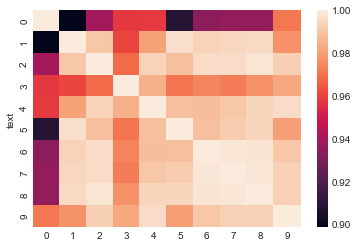

Key:
0 I have said you should speak presently.
1 And I see very few pearls in the room except mine.
2 O Cicero, I haue seene Tempests, when the scolding Winds Haue riu'd the knottie Oakes, and I haue seene Th' ambitious Ocean swell, and rage, and foame, To be exalted with the threatning Clouds:
3 You see he wasn't well enough acquainted with Buster to know that Buster is quite as smart as he is, and perhaps a little bit smarter.
4 It is I, you women, I make my way, I am stern, acrid, large, undissuadable, but I love you, I do not hurt you any more than is necessary for you, I pour the stuff to start sons and daughters fit for these States, I press with slow rude muscle, I brace myself effectually, I listen to no entreaties, I dare not withdraw till I deposit what has so long accumulated within me.
5 He shipp'd as green-hand boy, and sail'd away, (took some sudden, vehement notion;)
6 You see, I wanted to go into the detective service, especially the anti-dynamite business.
7 There was 

In [86]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])

## Supervised Learning Classification Models 

I'm going to attempt the supervised classification models with and without the k-means clustering predictions as features to see how well the different models perform. I will use GridSearchCV to make sure I can obtain the best scores. 